##Librerias

In [2]:
!pip install tensorflow
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
# tf.python.control_flow_ops = tf #esta línea evita un conflicto entre Keras y Tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from scikeras.wrappers import KerasClassifier


import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import   OneHotEncoder, StandardScaler



In [5]:
from tensorflow.python.client import device_lib

def gpuon():
    local_device_protos = device_lib.list_local_devices()
    print([x.name for x in local_device_protos if x.device_type == 'GPU'])

gpuon()

['/device:GPU:0']


In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 10 14:10:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |    312MiB / 15109MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


##Carga de datos

In [10]:
df_all = pd.read_csv("/content/drive/MyDrive/TFM/datos/df_all.csv", sep = ";")

FileNotFoundError: ignored

In [11]:
df_all.index = df_all.fecha  ##Set_index('fecha')
df_all = df_all.drop('fecha', axis=1)
df_all

NameError: ignored

In [ ]:
df_all.shape

#1.1 Division de datos
---



In [ ]:
df_train = df_all.loc['2015-01-01':'2020-12-31'] # 6 años de train
df_test = df_all.loc['2021-01-01':'2022-12-31']  # 1 año y medio de test

In [ ]:
X_train = df_train.drop('ocurrencia', axis=1)
y_train = df_train['ocurrencia']

X_test = df_test.drop('ocurrencia', axis=1)
y_test = df_test['ocurrencia']

In [ ]:
df_all.shape, df_train.shape,  X_train.shape, y_train.shape, df_test.shape, X_test.shape, y_test.shape

((488345, 25),
 (413052, 25),
 (413052, 24),
 (413052,),
 (75293, 25),
 (75293, 24),
 (75293,))

#1.2 Normalización

In [ ]:
# normalizacion de los datos numericos
from sklearn.preprocessing import StandardScaler
numericalCols_train = df_train[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total", "total_viajes_estacion" ]] 
numericalCols_test = df_test[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total", "total_viajes_estacion"  ]] 
scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((413052, 13), (75293, 13))

In [ ]:
# normalizacion de los datos categoricos , sin la ocurrencia
from sklearn.preprocessing import OneHotEncoder
categoricalCols_train = df_train[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()


# normalizacion de los datos categoricos , sin la ocurrencia
from sklearn.preprocessing import OneHotEncoder
categoricalCols_test = df_test[['alto_riesgo',	'peligro',	'vulner']]   #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((413052, 12), (75293, 12))

In [ ]:
Other_var_train = df_train[['laborable', 	'dayofyear', 	'weekend', 	'mes']]
Other_var_test = df_test[['laborable', 	'dayofyear', 	'weekend', 	'mes']]  #alto_riesgo	peligro	 y vulner

In [ ]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)
df_train_scaled.shape, df_test_scaled.shape

((413052, 29), (75293, 29))

In [ ]:
X_test = df_test_scaled
X_train = df_train_scaled

# 1.3. Model LSTM (df_all_sin_mov)

Vamos a generar una LSTM con dos capas

1. LSTM - Es la capa que trabaja en la clasificación. Donde se indica el numero de neuronas
2. Capa de dropout (apagado de neuronas)
3. Capa de activacion sigmoide ya que estamos ante una clasificación biaria (0-1)
4. Una única neurona de salida con un sigmoide

In [ ]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer

def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32):
    model=Sequential()
    model.add(InputLayer((29,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(29, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
model = modelLSTM()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 29)                5829      
                                                                 
 dropout_3 (Dropout)         (None, 29)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 30        
                                                                 
Total params: 167,459
Trainable params: 167,459
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
12899/12908 [============================>.] - ETA: 0s - loss: 0.0392 - accuracy: 0.9937

12908/12908 [==============================] - 78s 5ms/step - loss: 0.0392 - accuracy: 0.9937 - val_loss: 0.0426 - val_accuracy: 0.9929
Epoch 2/20
12908/12908 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9940

12908/12908 [==============================] - 71s 6ms/step - loss: 0.0380 - accuracy: 0.9940 - val_loss: 0.0425 - val_accuracy: 0.9929
Epoch 3/20
12908/12908 [==============================] - 66s 5ms/step - loss: 0.0378 - accuracy: 0.9940 - val_loss: 0.0426 - val_accuracy: 0.9929
Epoch 4/20
12908/12908 [==============================] - 66s 5ms/step - loss: 0.0376 - accuracy: 0.9940 - val_loss: 0.0425 - val_accuracy: 0.9929
Epoch 5/20
12907/12908 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9940

12908/12908 [==============================] - 69s 5ms/step - loss: 0.0369 - accuracy: 0.9940 - val_loss: 0.0413 - val_accuracy: 0.9929
Epoch 6/20
12908/12908 [==============================] - 65s 5ms/step - loss: 0.0367 - accuracy: 0.9940 - val_loss: 0.0429 - val_accuracy: 0.9929
Epoch 7/20
12908/12908 [==============================] - 65s 5ms/step - loss: 0.0366 - accuracy: 0.9940 - val_loss: 0.0413 - val_accuracy: 0.9929
Epoch 8/20
12905/12908 [============================>.] - ETA: 0s - loss: 0.0361 - accuracy: 0.9940

12908/12908 [==============================] - 69s 5ms/step - loss: 0.0361 - accuracy: 0.9940 - val_loss: 0.0406 - val_accuracy: 0.9929
Epoch 9/20
12908/12908 [==============================] - 65s 5ms/step - loss: 0.0358 - accuracy: 0.9940 - val_loss: 0.0406 - val_accuracy: 0.9929
Epoch 10/20
12908/12908 [==============================] - 66s 5ms/step - loss: 0.0358 - accuracy: 0.9940 - val_loss: 0.0407 - val_accuracy: 0.9929
Epoch 11/20
12906/12908 [============================>.] - ETA: 0s - loss: 0.0356 - accuracy: 0.9940

12908/12908 [==============================] - 69s 5ms/step - loss: 0.0356 - accuracy: 0.9940 - val_loss: 0.0402 - val_accuracy: 0.9929
Epoch 12/20
12905/12908 [============================>.] - ETA: 0s - loss: 0.0354 - accuracy: 0.9940

12908/12908 [==============================] - 69s 5ms/step - loss: 0.0354 - accuracy: 0.9940 - val_loss: 0.0400 - val_accuracy: 0.9929
Epoch 13/20
12900/12908 [============================>.] - ETA: 0s - loss: 0.0353 - accuracy: 0.9940

12908/12908 [==============================] - 69s 5ms/step - loss: 0.0353 - accuracy: 0.9940 - val_loss: 0.0398 - val_accuracy: 0.9929
Epoch 14/20
12908/12908 [==============================] - 65s 5ms/step - loss: 0.0351 - accuracy: 0.9940 - val_loss: 0.0399 - val_accuracy: 0.9929
Epoch 15/20
12908/12908 [==============================] - 65s 5ms/step - loss: 0.0351 - accuracy: 0.9940 - val_loss: 0.0405 - val_accuracy: 0.9929
Epoch 16/20
12908/12908 [==============================] - 66s 5ms/step - loss: 0.0351 - accuracy: 0.9940 - val_loss: 0.0405 - val_accuracy: 0.9929
Epoch 17/20
12908/12908 [==============================] - 65s 5ms/step - loss: 0.0350 - accuracy: 0.9940 - val_loss: 0.0403 - val_accuracy: 0.9929
Epoch 18/20
12908/12908 [==============================] - 65s 5ms/step - loss: 0.0350 - accuracy: 0.9940 - val_loss: 0.0404 - val_accuracy: 0.9929
Epoch 19/20
12908/12908 [==============================] - 65s 5ms/step - loss: 0.0352 - accuracy: 0.9940 - val_loss: 0.0400

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

2353/2353 - 6s - loss: 0.0404 - accuracy: 0.9929 - 6s/epoch - 2ms/step
accuracy: 99.29%


In [ ]:
y_pred_model_1 = model.predict(X_test)

2353/2353 [==============================] - 5s 2ms/step


In [ ]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test, y_pred_model1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     74755
           1       0.00      0.00      0.00       538

    accuracy                           0.99     75293
   macro avg       0.50      0.50      0.50     75293
weighted avg       0.99      0.99      0.99     75293



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[74755     0]
 [  538     0]]


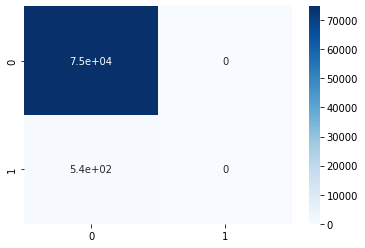

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

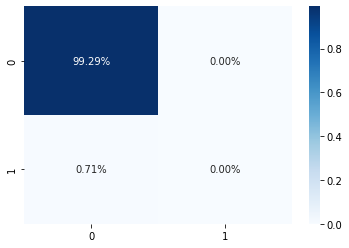

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

#Division de datos (UnderSampler Manual)

In [ ]:
df_sin_mov = df_all.loc['2015-01-01':'2022-12-31']

In [ ]:
df_all.groupby("ocurrencia").count()

,indicativo,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,...,peligro,vulner,municipio,cod_municipio,total_viajes_estacion,total_viajes_km_estacion,laborable,dayofyear,weekend,mes
ocurrencia,,,,,,,,,,,,,,,,,,,,,
0,485316,485316,485316,485316,485316,485316,485316,485316,485316,485316,...,485316,485316,485316,485316,485316,485316,485316,485316,485316,485316
1,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029,...,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029


In [ ]:
df_all.groupby("ocurrencia").count().columns

Index(['indicativo', 'prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha',
       'sol', 'presMax', 'presMin', 'rhum', 'altitud',
       'porcentaje_pendiente_total', 'alto_riesgo', 'peligro', 'vulner',
       'municipio', 'cod_municipio', 'total_viajes_estacion',
       'total_viajes_km_estacion', 'laborable', 'dayofyear', 'weekend', 'mes'],
      dtype='object')

In [ ]:
df_ocurrencia_0 = df_all[df_all["ocurrencia"]==0].sample(3029)

In [ ]:
df_ocurrencia_1 = df_all[df_all["ocurrencia"]==1]

In [ ]:
df_all =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_all.shape

(6058, 25)

In [ ]:
x = df_all['indicativo'].unique()
len(x)

197

In [ ]:
X = df_all.drop( ['ocurrencia', 'municipio', 'cod_municipio', 'indicativo', 'total_viajes_km_estacion'], axis=1)
y = df_all['ocurrencia']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train

,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,rhum,altitud,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,total_viajes_estacion,laborable,dayofyear,weekend,mes
fecha,,,,,,,,,,,,,,,,,,,,
2016-02-06,0.0,17.6,16.8,16.0,3.8,7.0,598.0,1018.0,1017.3,60.0,73.0,1.70,Sí,Molt Alt,Moderada,0.00,5,37,1,2
2018-11-06,0.0,12.7,12.3,12.0,2.7,5.0,371.0,1009.5,1009.1,68.0,381.0,6.80,Sí,Molt Alt,Moderada,0.00,1,310,0,11
2020-05-08,0.0,21.6,21.1,20.5,4.8,7.5,759.0,1017.1,1016.1,78.0,11.0,3.50,Sí,Alt,Baixa,20907.26,4,129,0,5
2018-12-24,0.0,17.4,17.1,16.7,0.5,2.0,405.0,998.3,997.9,49.0,348.0,3.50,Sí,Exclos,Moderada,0.00,0,358,0,12
2019-12-08,0.0,13.8,13.6,13.2,3.5,7.4,428.0,1021.9,1021.5,64.0,73.0,1.70,Sí,Molt Alt,Moderada,0.00,6,342,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-06,2.0,14.0,9.2,4.4,2.2,8.1,0.0,980.8,970.9,94.0,277.0,3.22,Sí,Alt,Mitja,0.00,2,65,0,3
2019-03-06,0.0,16.0,15.4,15.2,0.9,2.9,173.0,1001.4,1000.8,83.0,87.0,1.70,Sí,Molt Alt,Molt Alta,0.00,2,65,0,3
2019-03-07,0.0,13.9,13.4,13.0,2.1,5.7,745.0,935.4,935.0,43.0,376.0,2.80,Sí,Molt Alt,Moderada,0.00,3,66,0,3


# 1.2. Normalizacion datos



In [ ]:
# normalizacion de los datos numericos
numericalCols_train = X_train[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total", "total_viajes_estacion"]]  
numericalCols_test = X_test[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total", "total_viajes_estacion"]]  

scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((4846, 13), (1212, 13))

In [ ]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train = X_train[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()

# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test = X_test[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((4846, 12), (1212, 12))

In [ ]:
Other_var_train = X_train[['laborable', 	'dayofyear', 	'weekend', 	'mes']]
Other_var_test = X_test[['laborable', 	'dayofyear', 	'weekend', 	'mes']]  #alto_riesgo	peligro	 y vulner

In [ ]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)

In [ ]:
df_train_scaled.shape, y_train.shape, df_test_scaled.shape, y_test.shape

((4846, 29), (4846,), (1212, 29), (1212,))

In [ ]:
X_train = df_train_scaled.reshape(df_train_scaled.shape[0],df_train_scaled.shape[1],1)
X_train.shape, y_train.shape

((4846, 29, 1), (4846,))

In [ ]:
X_test = df_test_scaled.reshape(df_test_scaled.shape[0],df_test_scaled.shape[1],1)
X_test.shape, y_test.shape

((1212, 29, 1), (1212,))

# 1.3. Model LSTM (df_all-  UnderSampling Manual)

Vamos a generar una LSTM con dos capas

1. LSTM - Es la capa que trabaja en la clasificación. Donde se indica el numero de neuronas
2. Capa de dropout (apagado de neuronas)
3. Capa de activacion sigmoide ya que estamos ante una clasificación biaria (0-1)
4. Una única neurona de salida con un sigmoide

In [ ]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer

def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32):
    model=Sequential()
    model.add(InputLayer((29,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(29, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
model = modelLSTM()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               161600    
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 29)                5829      
                                                                 
 dropout_5 (Dropout)         (None, 29)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 30        
                                                                 
Total params: 167,459
Trainable params: 167,459
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
152/152 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.6209

152/152 [==============================] - 7s 33ms/step - loss: 0.6422 - accuracy: 0.6209 - val_loss: 0.8278 - val_accuracy: 0.6411
Epoch 2/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6289 - accuracy: 0.6341 - val_loss: 0.8473 - val_accuracy: 0.5536
Epoch 3/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6201 - accuracy: 0.6432 - val_loss: 0.8790 - val_accuracy: 0.5561
Epoch 4/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6237 - accuracy: 0.6428 - val_loss: 0.8850 - val_accuracy: 0.2492
Epoch 5/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6167 - accuracy: 0.6416 - val_loss: 0.8772 - val_accuracy: 0.5132
Epoch 6/20
149/152 [============================>.] - ETA: 0s - loss: 0.6160 - accuracy: 0.6470

152/152 [==============================] - 5s 32ms/step - loss: 0.6155 - accuracy: 0.6486 - val_loss: 0.7661 - val_accuracy: 0.6683
Epoch 7/20
152/152 [==============================] - 1s 9ms/step - loss: 0.6138 - accuracy: 0.6428 - val_loss: 1.0628 - val_accuracy: 0.0124
Epoch 8/20
152/152 [==============================] - 1s 9ms/step - loss: 0.6137 - accuracy: 0.6463 - val_loss: 0.8938 - val_accuracy: 0.5998
Epoch 9/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6147 - accuracy: 0.6548 - val_loss: 1.0132 - val_accuracy: 0.0734
Epoch 10/20
149/152 [============================>.] - ETA: 0s - loss: 0.6148 - accuracy: 0.6516

152/152 [==============================] - 5s 31ms/step - loss: 0.6159 - accuracy: 0.6513 - val_loss: 0.6988 - val_accuracy: 0.6452
Epoch 11/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6117 - accuracy: 0.6554 - val_loss: 0.9168 - val_accuracy: 0.5487
Epoch 12/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6082 - accuracy: 0.6643 - val_loss: 0.8526 - val_accuracy: 0.4761
Epoch 13/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6070 - accuracy: 0.6552 - val_loss: 0.8197 - val_accuracy: 0.6304
Epoch 14/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6074 - accuracy: 0.6558 - val_loss: 1.0156 - val_accuracy: 0.0413
Epoch 15/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6014 - accuracy: 0.6579 - val_loss: 0.9360 - val_accuracy: 0.4711
Epoch 16/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6023 - accuracy: 0.6649 - val_loss: 0.9819 - val_accuracy: 0.3119
Epoch 17/2

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

38/38 - 0s - loss: 0.7869 - accuracy: 0.5479 - 101ms/epoch - 3ms/step
accuracy: 54.79%


In [ ]:
y_pred_model_1 = model.predict(X_test)

38/38 [==============================] - 0s 2ms/step


In [ ]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test, y_pred_model1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    1212.0

    accuracy                           0.00    1212.0
   macro avg       0.00      0.00      0.00    1212.0
weighted avg       0.00      0.00      0.00    1212.0



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

[[   0    0]
 [1212    0]]


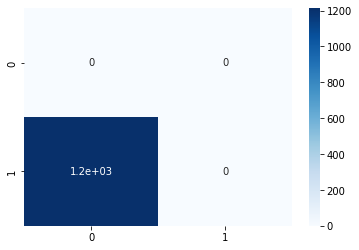

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

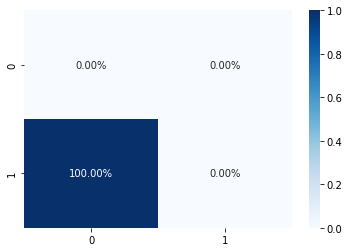

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# 1.3.1 GridSearch -  Modelo LSTM con division manual (X_train y_train)

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.643619 using {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.643619 (0.017591) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.455650 (0.066721) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.396207 (0.028737) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.638264 (0.031182) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.440583 (0.054462) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.376600 (0.003159) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [ ]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7fe6d70111f0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

[[  0   0]
 [684 528]]


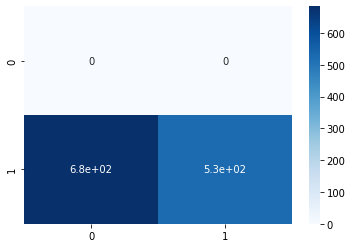

In [ ]:
y_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.42      0.59      1212

    accuracy                           0.42      1212
   macro avg       0.50      0.21      0.29      1212
weighted avg       1.00      0.42      0.59      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


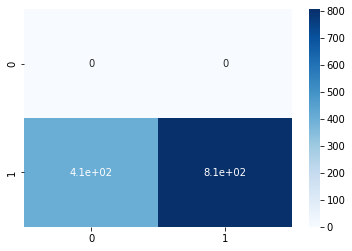

In [ ]:
y_pred = (final_model.predict_proba(X_test)[:,1] >= 0.41).astype(bool)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.67      0.80      1212

    accuracy                           0.67      1212
   macro avg       0.50      0.33      0.40      1212
weighted avg       1.00      0.67      0.80      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 1.4. Model LSTM clases balanceadas con SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE 
X_smote , y_smote = SMOTE().fit_resample( df_train_scaled, y_train)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote == 0)))

Before OverSampling, counts of label '1': 1817
Before OverSampling, counts of label '0': 3029 

After OverSampling, the shape of train_X: (6058, 29)
After OverSampling, the shape of train_y: (6058,) 

After OverSampling, counts of label '1': 3029
After OverSampling, counts of label '0': 3029


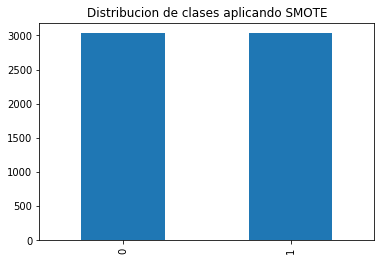

In [ ]:
pd.Series(y_smote).value_counts().plot(kind='bar', title='Distribucion de clases aplicando SMOTE')

Este gráfico muestra claramente que ahora tenemos una gran cantidad de incendios que antes no teníamos. Esos son todos los puntos de datos sintéticos que se ha creado con SMOTE.



In [ ]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_smote = X_smote.reshape(X_smote.shape[0],X_smote.shape[1],1)
X_smote.shape, y_smote.shape

((6058, 29, 1), (6058,))

In [ ]:
X_smote_float=X_smote.astype(np.float32)

In [ ]:
y_smote_int = y_smote.astype(np.int32)

In [ ]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=5)

model_smote = modelLSTM(200, 'sigmoid', 0.2,'adam')

model_smote.fit(X_smote_float, y_smote_int,validation_data=(X_test, y_test),epochs=20,callbacks=[cp, earlyStop])

Epoch 1/20
184/190 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.5853

190/190 [==============================] - 7s 31ms/step - loss: 0.6742 - accuracy: 0.5881 - val_loss: 0.5867 - val_accuracy: 0.8185
Epoch 2/20
190/190 [==============================] - 1s 5ms/step - loss: 0.6503 - accuracy: 0.6312 - val_loss: 0.7395 - val_accuracy: 0.6304
Epoch 3/20
189/190 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.5848

190/190 [==============================] - 6s 33ms/step - loss: 0.6667 - accuracy: 0.5848 - val_loss: 0.5854 - val_accuracy: 0.8960
Epoch 4/20
190/190 [==============================] - 1s 6ms/step - loss: 0.6695 - accuracy: 0.5746 - val_loss: 0.6755 - val_accuracy: 0.6650
Epoch 5/20
189/190 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6088

190/190 [==============================] - 5s 26ms/step - loss: 0.6580 - accuracy: 0.6091 - val_loss: 0.5804 - val_accuracy: 0.8003
Epoch 6/20
190/190 [==============================] - 1s 5ms/step - loss: 0.6420 - accuracy: 0.6397 - val_loss: 0.6057 - val_accuracy: 0.7211
Epoch 7/20
190/190 [==============================] - 1s 5ms/step - loss: 0.6332 - accuracy: 0.6555 - val_loss: 0.6049 - val_accuracy: 0.7459
Epoch 8/20
190/190 [==============================] - 1s 7ms/step - loss: 0.6275 - accuracy: 0.6527 - val_loss: 0.5946 - val_accuracy: 0.7483
Epoch 9/20
190/190 [==============================] - 1s 5ms/step - loss: 0.6285 - accuracy: 0.6601 - val_loss: 0.5933 - val_accuracy: 0.7294
Epoch 10/20
190/190 [==============================] - 1s 5ms/step - loss: 0.6277 - accuracy: 0.6590 - val_loss: 0.7079 - val_accuracy: 0.6477
Epoch 10: early stopping


In [ ]:
scores = model_smote.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_smote.metrics_names[1], scores[1] * 100))


38/38 - 0s - loss: 0.7079 - accuracy: 0.6477 - 100ms/epoch - 3ms/step
accuracy: 64.77%


In [ ]:
# print classification report
y_pred_model_bal = model_smote.predict(X_test)

y_pred_model_bal_1 = np.argmax(y_pred_model_bal, axis=1)
print(classification_report(y_test, y_pred_model_bal_1))

38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    1212.0

    accuracy                           0.00    1212.0
   macro avg       0.00      0.00      0.00    1212.0
weighted avg       0.00      0.00      0.00    1212.0



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

[[   0    0]
 [1212    0]]


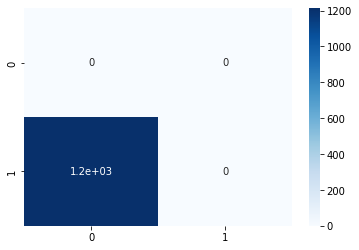

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model_bal_1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True,  cmap='Blues')

# 1.4.1 GridSearch - Modelo LSTM con division manual (X_smote_float, y_smote_int)

In [ ]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_smote_float, y_smote_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.662768 using {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.647419 (0.047939) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.556952 (0.029519) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.513036 (0.015112) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.662768 (0.031586) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.529716 (0.028847) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.503795 (0.007595) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [ ]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7fe6d70111f0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

[[  0   0]
 [542 670]]


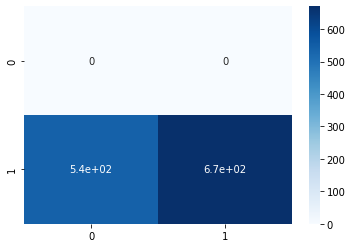

In [ ]:
y_pred = final_model.predict(X_test.astype('float32'))

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.55      0.71      1212

    accuracy                           0.55      1212
   macro avg       0.50      0.28      0.36      1212
weighted avg       1.00      0.55      0.71      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0   0]
 [554 658]]


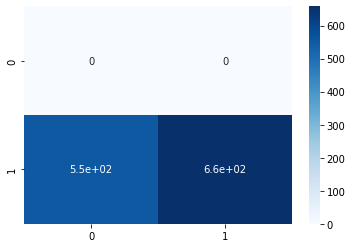

In [ ]:
y_pred = (final_model.predict_proba(X_test.astype('float32'))[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.54      0.70      1212

    accuracy                           0.54      1212
   macro avg       0.50      0.27      0.35      1212
weighted avg       1.00      0.54      0.70      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 1.5. Model LSTM clases balanceadas con RandomUnderSampler (y_train)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

X_rus , y_rus = RandomUnderSampler().fit_resample(df_train_scaled, y_train)


print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_rus.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_rus.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_rus == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_rus == 0)))

Before OverSampling, counts of label '1': 1817
Before OverSampling, counts of label '0': 3029 

After OverSampling, the shape of train_X: (3634, 29)
After OverSampling, the shape of train_y: (3634,) 

After OverSampling, counts of label '1': 1817
After OverSampling, counts of label '0': 1817


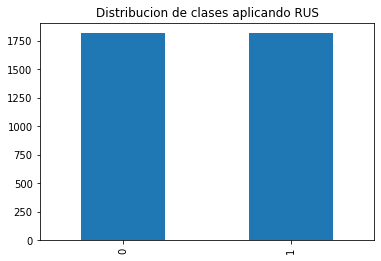

In [ ]:
pd.Series(y_rus).value_counts().plot(kind='bar', title='Distribucion de clases aplicando RUS')

In [ ]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_rus = X_rus.reshape(X_rus.shape[0],X_rus.shape[1],1)
X_rus.shape, y_rus.shape

((3634, 29, 1), (3634,))

In [ ]:
X_rus_float=X_rus.astype(np.float32)

In [ ]:
y_rus_int = y_rus.astype(np.int32)

In [ ]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=10)

model_rus = modelLSTM(200, 'sigmoid', 0.2, 'adam')

model_rus.fit(X_rus_float, y_rus_int, validation_data=(X_test, y_test),epochs=20,callbacks=[cp, earlyStop])


Epoch 1/20
114/114 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.5669

114/114 [==============================] - 6s 43ms/step - loss: 0.6850 - accuracy: 0.5669 - val_loss: 0.5925 - val_accuracy: 0.8399
Epoch 2/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6628 - accuracy: 0.6068 - val_loss: 0.7154 - val_accuracy: 0.7756
Epoch 3/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6575 - accuracy: 0.6219 - val_loss: 0.6842 - val_accuracy: 0.7459
Epoch 4/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6499 - accuracy: 0.6241 - val_loss: 0.6729 - val_accuracy: 0.6584
Epoch 5/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6609 - accuracy: 0.6233 - val_loss: 0.6764 - val_accuracy: 0.6312
Epoch 6/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6524 - accuracy: 0.6227 - val_loss: 0.6653 - val_accuracy: 0.5866
Epoch 7/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6582 - accuracy: 0.6046 - val_loss: 0.6339 - val_accuracy: 0.5602
Epoch 8/20
114/1

In [ ]:
scores = model_rus.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_rus.metrics_names[1], scores[1] * 100))


38/38 - 0s - loss: 0.6825 - accuracy: 0.7533 - 112ms/epoch - 3ms/step
accuracy: 75.33%


In [ ]:
# print classification report
y_pred_model_rus = model_rus.predict(X_test)

y_pred_model_rus_1 = np.argmax(y_pred_model_rus, axis=1)
print(classification_report(y_test, y_pred_model_rus_1))

38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    1212.0

    accuracy                           0.00    1212.0
   macro avg       0.00      0.00      0.00    1212.0
weighted avg       0.00      0.00      0.00    1212.0



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

[[   0    0]
 [1212    0]]


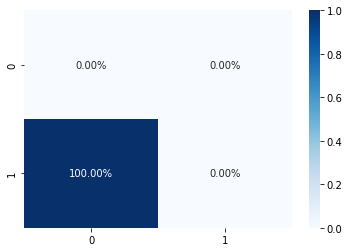

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model_rus_1)
print(cf_matrix)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# 1.5.1 GridSearch - Modelo LSTM con division manual (X_rus_float, y_rus_int)




In [ ]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_rus_float, y_rus_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.635938 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.607036 (0.041587) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.509629 (0.012303) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.501376 (0.003137) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.603735 (0.061024) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.507428 (0.015208) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000615) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [ ]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7fe6d70111f0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

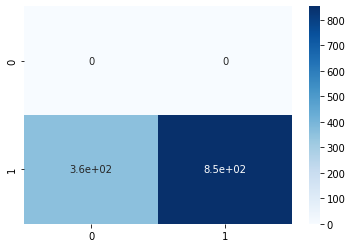

In [ ]:
y_pred = final_model.predict(X_test.astype('float32'))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.70      0.83      1212

    accuracy                           0.70      1212
   macro avg       0.50      0.35      0.41      1212
weighted avg       1.00      0.70      0.83      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


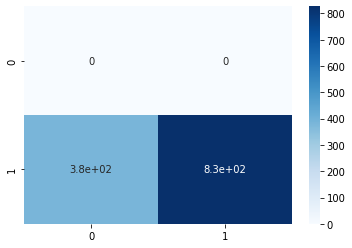

In [ ]:
y_pred = (final_model.predict_proba(X_test.astype('float32'))[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.68      0.81      1212

    accuracy                           0.68      1212
   macro avg       0.50      0.34      0.41      1212
weighted avg       1.00      0.68      0.81      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 1.6. Model LSTM con pesos definidos por class_weight

In [ ]:
#Definimos los pesos para el balanceo de clases.
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 0.7999339716077913, 1: 1.333516785910842}


In [ ]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=8)

model_1 = modelLSTM(150, 'sigmoid', 0.3, 'adam')

model_1.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20,class_weight=class_weights, callbacks=[cp, earlyStop])

Epoch 1/20
144/152 [===========================>..] - ETA: 0s - loss: 0.6903 - accuracy: 0.5625

152/152 [==============================] - 6s 33ms/step - loss: 0.6887 - accuracy: 0.5640 - val_loss: 0.6465 - val_accuracy: 0.7616
Epoch 2/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6599 - accuracy: 0.6096 - val_loss: 0.6729 - val_accuracy: 0.4200
Epoch 3/20
143/152 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.5699

152/152 [==============================] - 5s 33ms/step - loss: 0.6765 - accuracy: 0.5733 - val_loss: 0.5870 - val_accuracy: 0.8936
Epoch 4/20
143/152 [===========================>..] - ETA: 0s - loss: 0.6721 - accuracy: 0.5503

152/152 [==============================] - 5s 31ms/step - loss: 0.6730 - accuracy: 0.5518 - val_loss: 0.5673 - val_accuracy: 0.8795
Epoch 5/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6658 - accuracy: 0.5543 - val_loss: 0.7033 - val_accuracy: 0.7830
Epoch 6/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6652 - accuracy: 0.5518 - val_loss: 0.6754 - val_accuracy: 0.7937
Epoch 7/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6626 - accuracy: 0.5584 - val_loss: 0.5729 - val_accuracy: 0.8647
Epoch 8/20
152/152 [==============================] - 1s 7ms/step - loss: 0.6620 - accuracy: 0.5739 - val_loss: 0.8173 - val_accuracy: 0.4868
Epoch 9/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6619 - accuracy: 0.5613 - val_loss: 0.6914 - val_accuracy: 0.6667
Epoch 10/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6619 - accuracy: 0.5592 - val_loss: 0.5896 - val_accuracy: 0.8556
Epoch 11/20
152

In [ ]:
scores = model_1.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

38/38 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.7929
Accuracy: 79.29%


In [ ]:
y_pred_model_2 = model_1.predict(X_test.astype('float32'))

38/38 [==============================] - 0s 2ms/step


In [ ]:
# print classification report
y_pred_model2 = np.argmax(y_pred_model_2, axis=1)
print(classification_report(y_test, y_pred_model2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    1212.0

    accuracy                           0.00    1212.0
   macro avg       0.00      0.00      0.00    1212.0
weighted avg       0.00      0.00      0.00    1212.0



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

[[   0    0]
 [1212    0]]


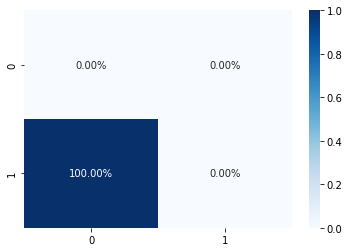

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model2)
print(cf_matrix)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# 2. Division de datos (Aleatoria)

---



In [51]:
from sklearn.model_selection import train_test_split

df_all = pd.read_csv("/content/drive/MyDrive/TFM/datos/df_all.csv", sep = ";")
df_all.index = df_all.fecha  ##Set_index('fecha')
df_all = df_all.drop('fecha', axis=1)

In [52]:
df_all = df_all.loc['2015-01-01':'2022-12-31']
print(df_all.shape)

(488345, 25)


In [53]:
df_all.groupby("ocurrencia").count()

,indicativo,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,...,peligro,vulner,municipio,cod_municipio,total_viajes_estacion,total_viajes_km_estacion,laborable,dayofyear,weekend,mes
ocurrencia,,,,,,,,,,,,,,,,,,,,,
0,485316,485316,485316,485316,485316,485316,485316,485316,485316,485316,...,485316,485316,485316,485316,485316,485316,485316,485316,485316,485316
1,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029,...,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029


In [54]:
df_ocurrencia_0 = df_all[df_all["ocurrencia"]==0].sample(3029)

In [55]:
df_ocurrencia_1 = df_all[df_all["ocurrencia"]==1]

In [56]:
df_all =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_all.shape

(6058, 25)

In [57]:
X = df_all.drop( ['ocurrencia', 'municipio', 'cod_municipio', 'indicativo'], axis=1)
y = df_all['ocurrencia']

In [58]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train_1

,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,rhum,...,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,total_viajes_estacion,total_viajes_km_estacion,laborable,dayofyear,weekend,mes
fecha,,,,,,,,,,,,,,,,,,,,,
2019-01-09,0.0,15.8,9.3,2.8,9.7,23.6,9.1,1011.4,1002.5,92.0,...,2.50,Sí,Exclos,Moderada,0.00,0.00,2,9,0,1
2019-09-04,0.0,30.0,29.1,28.1,3.9,7.2,876.0,940.1,939.8,29.0,...,5.00,Sí,Molt Alt,Moderada,0.00,0.00,2,247,0,9
2016-12-13,0.0,10.5,10.1,9.8,3.8,5.1,409.0,1001.7,1001.5,75.0,...,5.10,Sí,Molt Alt,Molt Alta,0.00,0.00,1,348,0,12
2016-09-24,0.0,23.5,22.8,22.3,3.0,6.8,223.0,981.7,981.2,65.0,...,3.22,Sí,Alt,Molt Alta,0.00,0.00,5,268,1,9
2020-05-08,0.0,26.0,25.5,24.5,1.9,4.8,980.0,997.0,996.7,37.0,...,3.22,Sí,Alt,Molt Alta,155346.56,1164505.62,4,129,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-16,0.0,23.3,22.8,22.5,3.9,8.3,990.0,1021.0,1020.7,32.0,...,2.50,Sí,Molt Alt,Moderada,0.00,0.00,0,137,0,5
2016-01-30,0.0,12.3,12.1,11.6,3.1,6.3,527.0,933.9,933.4,55.0,...,0.10,No,Baix,Alta,0.00,0.00,5,30,1,1
2022-01-23,0.0,11.9,11.1,10.2,0.4,2.2,515.0,1029.0,1028.7,45.0,...,0.50,Sí,Molt Alt,Moderada,0.00,0.00,6,23,1,1


#2.1 Normalizacion datos



In [59]:
# normalizacion de los datos numericos
from sklearn.preprocessing import StandardScaler
numericalCols_train_1 = X_train_1[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total", "total_viajes_estacion" ]] 
numericalCols_test_1 = X_test_1[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total", "total_viajes_estacion" ]] 

scaler = StandardScaler()
scaler.fit(numericalCols_train_1)

numericalCols_train_scaled_1 = scaler.transform(numericalCols_train_1)
numericalCols_test_scaled_1 = scaler.transform(numericalCols_test_1)

numericalCols_train_scaled_1.shape , numericalCols_test_scaled_1.shape

((4846, 13), (1212, 13))

In [60]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train_1 = X_train_1[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	vulner
categoricalCols_train_1 = OneHotEncoder().fit_transform(categoricalCols_train_1).toarray()

# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test_1 = X_test_1[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	 y vulner
categoricalCols_test_1 = OneHotEncoder().fit_transform(categoricalCols_test_1).toarray()

categoricalCols_train_1.shape, categoricalCols_test_1.shape

((4846, 12), (1212, 12))

In [61]:
Other_var_train_1 = X_train_1[['laborable', 	'dayofyear', 	'weekend', 	'mes']]
Other_var_test_1 = X_test_1[['laborable', 	'dayofyear', 	'weekend', 	'mes']]  #alto_riesgo	peligro	 y vulner

In [62]:
df_train_scaled_1 = np.concatenate((numericalCols_train_scaled_1 , categoricalCols_train_1, Other_var_train_1), axis=1)
df_test_scaled_1 = np.concatenate((numericalCols_test_scaled_1 , categoricalCols_test_1, Other_var_test_1), axis=1)

In [63]:
df_train_scaled_1.shape, y_train_1.shape, df_test_scaled_1.shape, y_test_1.shape

((4846, 29), (4846,), (1212, 29), (1212,))

In [64]:
X_train_1 = df_train_scaled_1.reshape(df_train_scaled_1.shape[0],df_train_scaled_1.shape[1],1)
X_train_1.shape, y_train_1.shape

((4846, 29, 1), (4846,))

In [65]:
X_test_1 = df_test_scaled_1.reshape(df_test_scaled_1.shape[0],df_test_scaled_1.shape[1],1)
X_test_1.shape, y_test_1.shape

((1212, 29, 1), (1212,))

# 2.2 Model LSTM (df_sin_mov - Division Aleatoria)

In [35]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer


def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32):
    model=Sequential()
    model.add(InputLayer((29,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(29, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
model_shuffle = modelLSTM()

In [ ]:
model_shuffle.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 200)               161600    
                                                                 
 dropout_20 (Dropout)        (None, 200)               0         
                                                                 
 dense_20 (Dense)            (None, 29)                5829      
                                                                 
 dropout_21 (Dropout)        (None, 29)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 30        
                                                                 
Total params: 167,459
Trainable params: 167,459
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model_shuffle.fit(X_train_1, y_train_1,validation_data=(X_test_1, y_test_1),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
146/152 [===========================>..] - ETA: 0s - loss: 0.6759 - accuracy: 0.5756

152/152 [==============================] - 7s 37ms/step - loss: 0.6750 - accuracy: 0.5776 - val_loss: 0.6391 - val_accuracy: 0.6584
Epoch 2/20
150/152 [============================>.] - ETA: 0s - loss: 0.6516 - accuracy: 0.6348

152/152 [==============================] - 5s 31ms/step - loss: 0.6516 - accuracy: 0.6348 - val_loss: 0.6375 - val_accuracy: 0.6469
Epoch 3/20
150/152 [============================>.] - ETA: 0s - loss: 0.6543 - accuracy: 0.6273

152/152 [==============================] - 5s 31ms/step - loss: 0.6539 - accuracy: 0.6281 - val_loss: 0.6318 - val_accuracy: 0.6551
Epoch 4/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6454 - accuracy: 0.6411 - val_loss: 0.6391 - val_accuracy: 0.6584
Epoch 5/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6489 - accuracy: 0.6391 - val_loss: 0.6402 - val_accuracy: 0.6345
Epoch 6/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6442 - accuracy: 0.6407 - val_loss: 0.6372 - val_accuracy: 0.6411
Epoch 7/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.6350 - val_loss: 0.6540 - val_accuracy: 0.6312
Epoch 8/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6625 - accuracy: 0.5993 - val_loss: 0.6497 - val_accuracy: 0.6238
Epoch 9/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6591 - accuracy: 0.6087 - val_loss: 0.6421 - val_accuracy: 0.6386
Epoch 10/20
152/

In [ ]:
scores = model_shuffle.evaluate(X_test_1, y_test_1, verbose=2)
print("%s: %.2f%%" % (model_shuffle.metrics_names[1], scores[1] * 100))

38/38 - 0s - loss: 0.6499 - accuracy: 0.6205 - 100ms/epoch - 3ms/step
accuracy: 62.05%


In [ ]:
y_pred_model_1 = model_shuffle.predict(X_test_1)

38/38 [==============================] - 0s 2ms/step


In [ ]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test_1, y_pred_model1))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       599
           1       0.00      0.00      0.00       613

    accuracy                           0.49      1212
   macro avg       0.25      0.50      0.33      1212
weighted avg       0.24      0.49      0.33      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[599   0]
 [613   0]]


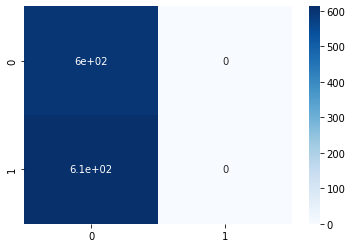

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test_1, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

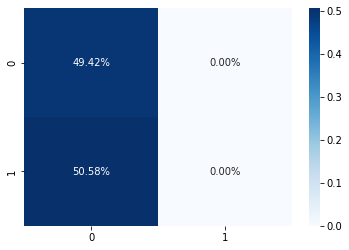

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# 2.2.1 GridSearch -  Hiperparametros del modelo LSTM con division aleatoria  (X_train_1, y_train_1)

In [ ]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_train_1, y_train_1)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.641558 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.635574 (0.017219) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.510321 (0.013721) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.630827 (0.015660) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.506398 (0.011619) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.641558 (0.007911) with: {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.513616 (0.020967) with: {'batch_size': 64, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}


In [ ]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f31ec8d0430>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

[[155 437]
 [165 455]]


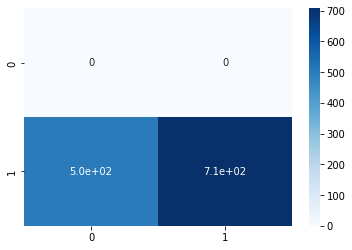

In [ ]:
y_pred = final_model.predict(X_test_1.astype('float32'))
print(cm)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.58      0.62       592
           1       0.65      0.74      0.69       620

    accuracy                           0.66      1212
   macro avg       0.66      0.66      0.66      1212
weighted avg       0.66      0.66      0.66      1212



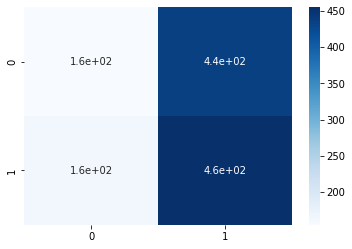

In [ ]:
y_pred = (final_model.predict_proba(X_test.astype('float32'))[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.26      0.34       592
           1       0.51      0.73      0.60       620

    accuracy                           0.50      1212
   macro avg       0.50      0.50      0.47      1212
weighted avg       0.50      0.50      0.47      1212



# 2.3. Model LSTM division aleatoria con SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE 
X_smote_1 , y_smote_1 = SMOTE().fit_resample( df_train_scaled_1, y_train_1)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train_1 == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train_1 == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_smote_1.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote_1.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_smote_1 == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote_1 == 0)))

Before OverSampling, counts of label '1': 2409
Before OverSampling, counts of label '0': 2437 

After OverSampling, the shape of train_X: (4874, 28)
After OverSampling, the shape of train_y: (4874,) 

After OverSampling, counts of label '1': 2437
After OverSampling, counts of label '0': 2437


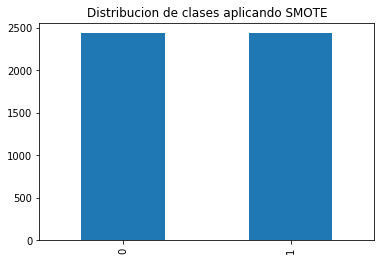

In [ ]:
pd.Series(y_smote_1).value_counts().plot(kind='bar', title='Distribucion de clases aplicando SMOTE')

Este gráfico muestra claramente que ahora tenemos una gran cantidad de incendios que antes no teníamos. Esos son todos los puntos de datos sintéticos que se ha creado con SMOTE.



In [ ]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_smote_1 = X_smote_1.reshape(X_smote_1.shape[0],X_smote_1.shape[1],1)
X_smote_1.shape, y_smote_1.shape

((4874, 28, 1), (4874,))

In [ ]:
X_smote_float_1 =X_smote_1.astype(np.float32)

In [ ]:
y_smote_int_1 = y_smote_1.astype(np.int32)

In [ ]:
X_test_1.shape, y_test_1.shape, X_smote_float_1.shape, y_smote_int_1.shape

((1212, 28, 1), (1212,), (4874, 28, 1), (4874,))

In [ ]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=10)

model_smote = modelLSTM(200, 'sigmoid', 0.2,'adam')

model_smote.fit(X_smote_float_1, y_smote_int_1,validation_data=(X_test_1, y_test_1),epochs=20,callbacks=[cp, earlyStop])

Epoch 1/20
149/153 [============================>.] - ETA: 0s - loss: 0.6742 - accuracy: 0.5879

153/153 [==============================] - 7s 33ms/step - loss: 0.6742 - accuracy: 0.5876 - val_loss: 0.6569 - val_accuracy: 0.6394
Epoch 2/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6578 - accuracy: 0.6202 - val_loss: 0.6656 - val_accuracy: 0.6155
Epoch 3/20
151/153 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.6229

153/153 [==============================] - 5s 30ms/step - loss: 0.6542 - accuracy: 0.6219 - val_loss: 0.6523 - val_accuracy: 0.6097
Epoch 4/20
151/153 [============================>.] - ETA: 0s - loss: 0.6468 - accuracy: 0.6213

153/153 [==============================] - 5s 32ms/step - loss: 0.6466 - accuracy: 0.6221 - val_loss: 0.6410 - val_accuracy: 0.6378
Epoch 5/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6430 - accuracy: 0.6317 - val_loss: 0.6473 - val_accuracy: 0.6436
Epoch 6/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.6274 - val_loss: 0.6560 - val_accuracy: 0.6394
Epoch 7/20
149/153 [============================>.] - ETA: 0s - loss: 0.6442 - accuracy: 0.6334

153/153 [==============================] - 5s 30ms/step - loss: 0.6454 - accuracy: 0.6332 - val_loss: 0.6407 - val_accuracy: 0.6378
Epoch 8/20
153/153 [==============================] - 1s 7ms/step - loss: 0.6447 - accuracy: 0.6280 - val_loss: 0.6473 - val_accuracy: 0.6254
Epoch 9/20
149/153 [============================>.] - ETA: 0s - loss: 0.6416 - accuracy: 0.6378

153/153 [==============================] - 5s 36ms/step - loss: 0.6412 - accuracy: 0.6389 - val_loss: 0.6403 - val_accuracy: 0.6295
Epoch 10/20
148/153 [============================>.] - ETA: 0s - loss: 0.6452 - accuracy: 0.6296

153/153 [==============================] - 5s 35ms/step - loss: 0.6446 - accuracy: 0.6311 - val_loss: 0.6328 - val_accuracy: 0.6584
Epoch 11/20
151/153 [============================>.] - ETA: 0s - loss: 0.6459 - accuracy: 0.6285

153/153 [==============================] - 5s 32ms/step - loss: 0.6451 - accuracy: 0.6295 - val_loss: 0.6319 - val_accuracy: 0.6502
Epoch 12/20
152/153 [============================>.] - ETA: 0s - loss: 0.6381 - accuracy: 0.6454

153/153 [==============================] - 5s 31ms/step - loss: 0.6378 - accuracy: 0.6459 - val_loss: 0.6317 - val_accuracy: 0.6469
Epoch 13/20
151/153 [============================>.] - ETA: 0s - loss: 0.6363 - accuracy: 0.6397

153/153 [==============================] - 4s 29ms/step - loss: 0.6361 - accuracy: 0.6399 - val_loss: 0.6236 - val_accuracy: 0.6658
Epoch 14/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6397 - accuracy: 0.6364 - val_loss: 0.6405 - val_accuracy: 0.6254
Epoch 15/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6358 - accuracy: 0.6422 - val_loss: 0.6237 - val_accuracy: 0.6551
Epoch 16/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6365 - accuracy: 0.6446 - val_loss: 0.6280 - val_accuracy: 0.6485
Epoch 17/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6335 - accuracy: 0.6418 - val_loss: 0.6329 - val_accuracy: 0.6617
Epoch 18/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6321 - accuracy: 0.6461 - val_loss: 0.6294 - val_accuracy: 0.6469
Epoch 19/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6354 - accuracy: 0.6453 - val_loss: 0.6246 - val_accuracy: 0.6576
Epoch 20/2

In [ ]:
scores = model_smote.evaluate(X_test_1, y_test_1, verbose=2)
print("%s: %.2f%%" % (model_smote.metrics_names[1], scores[1] * 100))


38/38 - 0s - loss: 0.6264 - accuracy: 0.6568 - 100ms/epoch - 3ms/step
accuracy: 65.68%


In [ ]:
# print classification report
y_pred_model_bal = model_smote.predict(X_test_1)

y_pred_model_bal_1 = np.argmax(y_pred_model_bal, axis=1)
print(classification_report(y_test_1, y_pred_model_bal_1))

38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       592
           1       0.00      0.00      0.00       620

    accuracy                           0.49      1212
   macro avg       0.24      0.50      0.33      1212
weighted avg       0.24      0.49      0.32      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[592   0]
 [620   0]]


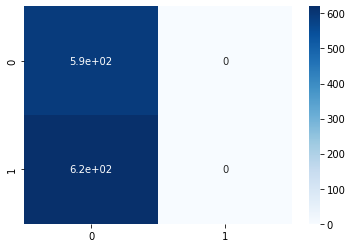

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test_1, y_pred_model_bal_1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True,  cmap='Blues')

# 2.3.1 GridSearch - Modelo LSTM con division aleatoria Smote (X_smote_float, y_smote_int)

In [ ]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_smote_float_1, y_smote_int_1)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.649365 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.631312 (0.020861) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000459) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000459) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.637879 (0.020991) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.539390 (0.030476) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000459) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [ ]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f31ec8d0430>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

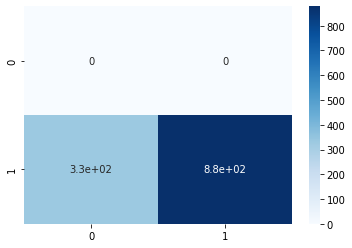

In [ ]:
y_pred = final_model.predict(X_test.astype('float32'))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.27      0.34       592
           1       0.51      0.72      0.59       620

    accuracy                           0.50      1212
   macro avg       0.49      0.49      0.47      1212
weighted avg       0.49      0.50      0.47      1212



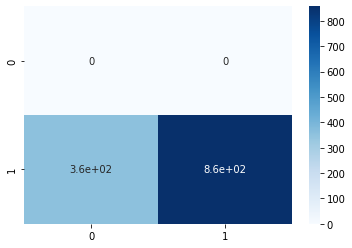

In [ ]:
y_pred = (final_model.predict_proba(X_test.astype('float32'))[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.29      0.36       592
           1       0.51      0.70      0.59       620

    accuracy                           0.50      1212
   macro avg       0.50      0.50      0.48      1212
weighted avg       0.50      0.50      0.48      1212



# 2.4 Model LSTM - Division Aleatoria - Balanceo de clases RandomUnderSampler (y_train_1)


In [29]:
from imblearn.under_sampling import RandomUnderSampler

X_rus , y_rus = RandomUnderSampler().fit_resample(df_train_scaled_1, y_train_1)

print("Before UnderSampling, counts of label '1': {}".format(sum(y_train_1 == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train_1 == 0)))

print('After UnderSampling, the shape of train_X: {}'.format(X_rus.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_rus.shape))
  
print("After UnderSampling, counts of label '1': {}".format(sum(y_rus == 1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_rus == 0)))

Before UnderSampling, counts of label '1': 2419
Before UnderSampling, counts of label '0': 2427 

After UnderSampling, the shape of train_X: (4838, 29)
After UnderSampling, the shape of train_y: (4838,) 

After UnderSampling, counts of label '1': 2419
After UnderSampling, counts of label '0': 2419


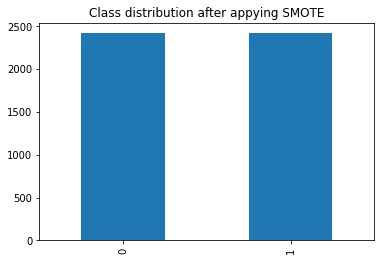

In [30]:
pd.Series(y_rus).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE')

In [31]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_rus = X_rus.reshape(X_rus.shape[0],X_rus.shape[1],1)
X_rus.shape, y_rus.shape

((4838, 29, 1), (4838,))

In [32]:
X_rus_float = X_rus.astype(np.float32)

In [33]:
y_rus_int = y_rus.astype(np.int32)

In [36]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=20)

model_shuffle_rus = modelLSTM(200, 'sigmoid', 0.2,'adam')

model_shuffle_rus.fit(X_rus_float, y_rus_int,validation_data=(X_test_1, y_test_1),epochs=20,callbacks=[cp, earlyStop])

Epoch 1/20
146/152 [===========================>..] - ETA: 0s - loss: 0.6689 - accuracy: 0.5940

152/152 [==============================] - 12s 35ms/step - loss: 0.6682 - accuracy: 0.5945 - val_loss: 0.6391 - val_accuracy: 0.6411
Epoch 2/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6427 - accuracy: 0.6406 - val_loss: 0.6409 - val_accuracy: 0.6436
Epoch 3/20
152/152 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.6432

152/152 [==============================] - 5s 33ms/step - loss: 0.6385 - accuracy: 0.6432 - val_loss: 0.6364 - val_accuracy: 0.6419
Epoch 4/20
146/152 [===========================>..] - ETA: 0s - loss: 0.6325 - accuracy: 0.6449

152/152 [==============================] - 5s 31ms/step - loss: 0.6328 - accuracy: 0.6443 - val_loss: 0.6292 - val_accuracy: 0.6353
Epoch 5/20
146/152 [===========================>..] - ETA: 0s - loss: 0.6311 - accuracy: 0.6426

152/152 [==============================] - 5s 33ms/step - loss: 0.6298 - accuracy: 0.6434 - val_loss: 0.6252 - val_accuracy: 0.6568
Epoch 6/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6307 - accuracy: 0.6468 - val_loss: 0.6254 - val_accuracy: 0.6592
Epoch 7/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6264 - accuracy: 0.6538 - val_loss: 0.6303 - val_accuracy: 0.6328
Epoch 8/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6290 - accuracy: 0.6488 - val_loss: 0.6325 - val_accuracy: 0.6188
Epoch 9/20
152/152 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.6461

152/152 [==============================] - 5s 30ms/step - loss: 0.6319 - accuracy: 0.6461 - val_loss: 0.6222 - val_accuracy: 0.6741
Epoch 10/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6268 - accuracy: 0.6474 - val_loss: 0.6241 - val_accuracy: 0.6518
Epoch 11/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6234 - accuracy: 0.6565 - val_loss: 0.6231 - val_accuracy: 0.6658
Epoch 12/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6236 - accuracy: 0.6581 - val_loss: 0.6225 - val_accuracy: 0.6518
Epoch 13/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6221 - accuracy: 0.6577 - val_loss: 0.6236 - val_accuracy: 0.6559
Epoch 14/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6182 - accuracy: 0.6561 - val_loss: 0.6301 - val_accuracy: 0.6650
Epoch 15/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6188 - accuracy: 0.6612 - val_loss: 0.6576 - val_accuracy: 0.6609
Epoch 16/2

152/152 [==============================] - 5s 33ms/step - loss: 0.6231 - accuracy: 0.6569 - val_loss: 0.6220 - val_accuracy: 0.6320
Epoch 17/20
149/152 [============================>.] - ETA: 0s - loss: 0.6211 - accuracy: 0.6590

152/152 [==============================] - 5s 30ms/step - loss: 0.6204 - accuracy: 0.6596 - val_loss: 0.6183 - val_accuracy: 0.6708
Epoch 18/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6219 - accuracy: 0.6637 - val_loss: 0.6225 - val_accuracy: 0.6650
Epoch 19/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6178 - accuracy: 0.6594 - val_loss: 0.6217 - val_accuracy: 0.6700
Epoch 20/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6216 - accuracy: 0.6621 - val_loss: 0.6199 - val_accuracy: 0.6700


In [37]:
scores = model_shuffle_rus.evaluate(X_test_1, y_test_1, verbose=2)
print("%s: %.2f%%" % (model_shuffle_rus.metrics_names[1], scores[1] * 100))


38/38 - 0s - loss: 0.6199 - accuracy: 0.6700 - 113ms/epoch - 3ms/step
accuracy: 67.00%


In [38]:
# print classification report
y_pred_model_bal = model_shuffle_rus.predict(X_test_1)

y_pred_model_bal_1 = np.argmax(y_pred_model_bal, axis=1)
print(classification_report(y_test_1, y_pred_model_bal_1))

38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       602
           1       0.00      0.00      0.00       610

    accuracy                           0.50      1212
   macro avg       0.25      0.50      0.33      1212
weighted avg       0.25      0.50      0.33      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[602   0]
 [610   0]]


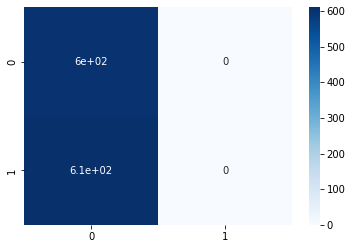

In [39]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test_1, y_pred_model_bal_1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True,  cmap='Blues')

# GridSearch - Modelo LSTM con division manual (X_rus, y_rus)

In [40]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_rus_float, y_rus_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.659571 using {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.646131 (0.017800) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.546300 (0.026491) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000327) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.659571 (0.016043) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.512405 (0.016554) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000327) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [41]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f1c123bcee0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

In [42]:
y_pred = final_model.predict(X_test_1.astype(np.float32))

In [43]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.56      0.60       602
           1       0.61      0.69      0.65       610

    accuracy                           0.62      1212
   macro avg       0.62      0.62      0.62      1212
weighted avg       0.62      0.62      0.62      1212



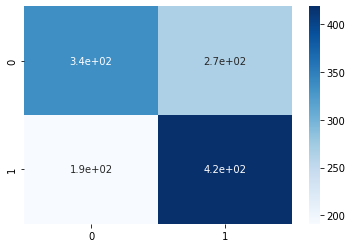

In [44]:
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

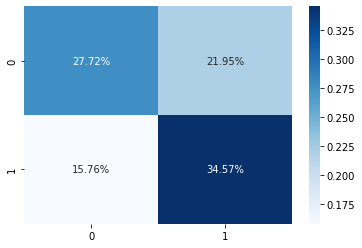

In [45]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

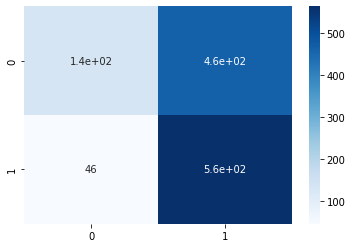

In [46]:
y_pred = (final_model.predict_proba(X_test_1.astype(np.float32))[:,1] >= 0.4).astype(bool)
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [47]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.23      0.35       602
           1       0.55      0.92      0.69       610

    accuracy                           0.58      1212
   macro avg       0.65      0.58      0.52      1212
weighted avg       0.65      0.58      0.52      1212



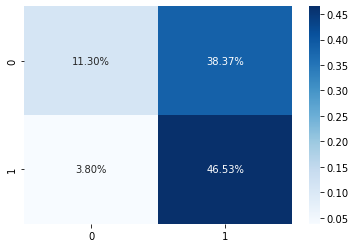

In [48]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

In [49]:
print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test_1, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test_1, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test_1, y_pred, average = "macro") :0.5f}')


Conjunto de datos de validación
  Exactitud:     0.57838
  Precisión:     0.64837
  Exhaustividad: 0.57608


In [50]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.23      0.35       602
           1       0.55      0.92      0.69       610

    accuracy                           0.58      1212
   macro avg       0.65      0.58      0.52      1212
weighted avg       0.65      0.58      0.52      1212



#Variables importantes (Modelo Simple)

---



#Seleccion de variables importantes (Modelo Simple)


In [ ]:
df_all.columns

Index(['indicativo', 'prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha',
       'sol', 'presMax', 'presMin', 'rhum', 'altitud',
       'porcentaje_pendiente_total', 'alto_riesgo', 'peligro', 'vulner',
       'ocurrencia', 'municipio', 'cod_municipio', 'total_viajes_estacion',
       'total_viajes_km_estacion', 'laborable', 'dayofyear', 'weekend', 'mes'],
      dtype='object')

In [ ]:
df_all_importances = df_all.drop([ 'indicativo', 'tmed', 'tmin', 'presMin', 'municipio', 'cod_municipio', 'porcentaje_pendiente_total','total_viajes_km_estacion','altitud', 'vulner', 'alto_riesgo', 'laborable', 'weekend'], axis=1)
df_all_importances

,prec,tmax,velmedia,racha,sol,presMax,rhum,peligro,ocurrencia,total_viajes_estacion,dayofyear,mes
fecha,,,,,,,,,,,,
2020-12-12,0.0,13.7,5.3,9.1,457.0,1006.2,70.0,Exclos,0,63537.48,347,12
2015-07-19,0.0,13.0,5.1,8.0,514.0,1001.8,78.0,Baix,0,0.00,200,7
2018-03-13,0.0,9.7,5.8,8.8,791.0,920.1,57.0,Moderat,0,0.00,72,3
2021-09-19,0.0,18.8,4.1,7.4,805.0,930.2,47.0,Molt Alt,0,0.00,262,9
2018-02-09,0.0,10.6,2.8,4.8,593.0,920.7,47.0,Molt Alt,0,0.00,40,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-21,0.0,11.9,1.8,4.0,450.0,1020.4,90.0,Moderat,1,0.00,355,12
2021-12-23,0.0,14.0,14.0,17.8,459.0,1003.0,76.0,Molt Alt,1,0.00,357,12
2021-12-29,0.0,18.1,1.6,4.1,309.0,1009.8,63.0,Exclos,1,0.00,363,12


In [ ]:
df_all_importances.groupby("ocurrencia").count()

,prec,tmax,velmedia,racha,sol,presMax,rhum,peligro,total_viajes_estacion,dayofyear,mes
ocurrencia,,,,,,,,,,,
0,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029
1,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029


In [ ]:
df_all_importances.groupby("ocurrencia").count().columns

Index(['prec', 'tmax', 'velmedia', 'racha', 'sol', 'presMax', 'rhum',
       'peligro', 'total_viajes_estacion', 'dayofyear', 'mes'],
      dtype='object')

In [ ]:
df_ocurrencia_0 = df_all_importances[df_all_importances["ocurrencia"]==0].sample(3029)

In [ ]:
df_ocurrencia_1 = df_all_importances[df_all_importances["ocurrencia"]==1]

In [ ]:
df_all_importances =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])

In [ ]:
X = df_all_importances.drop( ['ocurrencia'], axis=1)
y = df_all_importances['ocurrencia']


In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2)

In [ ]:
df_all.shape,  X_train_2.shape, y_train_2.shape, X_test_2.shape, y_test_2.shape

((6058, 25), (4846, 11), (4846,), (1212, 11), (1212,))

##Normalizacion

In [ ]:
# normalizacion de los datos numericos
numericalCols_train = X_train_2[['prec'	,'tmax',	'velmedia',	'racha',	'sol'	,'presMax',	'rhum']]
numericalCols_test = X_test_2[['prec'	,'tmax',	'velmedia',	'racha',	'sol'	,'presMax',	'rhum']]

scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((4846, 7), (1212, 7))

In [ ]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train = X_train_2[[	'peligro']]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()


# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test = X_test_2[['peligro']]   #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((4846, 5), (1212, 5))

In [ ]:
Other_var_train = X_train_2[[	'mes', 'dayofyear']]
Other_var_test = X_test_2[[	'mes', 'dayofyear']]  #alto_riesgo	peligro	 y vulner

In [ ]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)
df_train_scaled.shape

(4846, 14)

In [ ]:
X_test = df_test_scaled
X_train = df_train_scaled

##Model LSTM (Variables importantes)

In [ ]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer


def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 64):
    model=Sequential()
    model.add(InputLayer((14,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(14, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
model_import = modelLSTM()

In [ ]:
model_import.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 200)               161600    
                                                                 
 dropout_24 (Dropout)        (None, 200)               0         
                                                                 
 dense_24 (Dense)            (None, 14)                2814      
                                                                 
 dropout_25 (Dropout)        (None, 14)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 15        
                                                                 
Total params: 164,429
Trainable params: 164,429
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model_import.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
140/152 [==========================>...] - ETA: 0s - loss: 0.6786 - accuracy: 0.6145

152/152 [==============================] - 7s 32ms/step - loss: 0.6774 - accuracy: 0.6158 - val_loss: 0.9758 - val_accuracy: 0.0000e+00
Epoch 2/20
148/152 [============================>.] - ETA: 0s - loss: 0.6629 - accuracy: 0.6271

152/152 [==============================] - 5s 34ms/step - loss: 0.6640 - accuracy: 0.6251 - val_loss: 0.9484 - val_accuracy: 0.0000e+00
Epoch 3/20
151/152 [============================>.] - ETA: 0s - loss: 0.6640 - accuracy: 0.6252

152/152 [==============================] - 5s 31ms/step - loss: 0.6639 - accuracy: 0.6251 - val_loss: 0.9104 - val_accuracy: 0.0000e+00
Epoch 4/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6635 - accuracy: 0.6251 - val_loss: 1.0148 - val_accuracy: 0.0000e+00
Epoch 5/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6645 - accuracy: 0.6251 - val_loss: 0.9805 - val_accuracy: 0.0000e+00
Epoch 6/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6643 - accuracy: 0.6251 - val_loss: 0.9427 - val_accuracy: 0.0000e+00
Epoch 7/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6626 - accuracy: 0.6251 - val_loss: 0.9770 - val_accuracy: 0.0000e+00
Epoch 8/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6636 - accuracy: 0.6251 - val_loss: 0.9577 - val_accuracy: 0.0000e+00
Epoch 9/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6642 - accuracy: 0.6251 - val_loss: 0.9571 - val_accuracy:

152/152 [==============================] - 4s 30ms/step - loss: 0.6619 - accuracy: 0.6251 - val_loss: 0.9089 - val_accuracy: 0.0000e+00
Epoch 13/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6630 - accuracy: 0.6251 - val_loss: 0.9626 - val_accuracy: 0.0000e+00
Epoch 14/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6626 - accuracy: 0.6251 - val_loss: 1.0110 - val_accuracy: 0.0000e+00
Epoch 15/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6628 - accuracy: 0.6251 - val_loss: 1.0099 - val_accuracy: 0.0000e+00
Epoch 16/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6616 - accuracy: 0.6251 - val_loss: 0.9801 - val_accuracy: 0.0000e+00
Epoch 17/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6617 - accuracy: 0.6251 - val_loss: 0.9796 - val_accuracy: 0.0000e+00
Epoch 18/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6622 - accuracy: 0.6251 - val_loss: 0.9950 - val_acc

In [ ]:
scores = model_import.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_import.metrics_names[1], scores[1] * 100))

38/38 - 0s - loss: 0.9852 - accuracy: 0.0000e+00 - 96ms/epoch - 3ms/step
accuracy: 0.00%


In [ ]:
y_pred_model_1 = model_import.predict(X_test)

38/38 [==============================] - 0s 2ms/step


In [ ]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test_2, y_pred_model1))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       611
           1       0.00      0.00      0.00       601

    accuracy                           0.50      1212
   macro avg       0.25      0.50      0.34      1212
weighted avg       0.25      0.50      0.34      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[   0    0]
 [1212    0]]


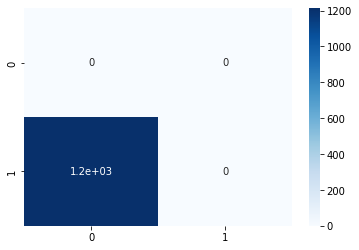

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

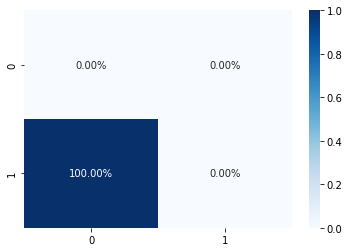

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')